In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load mean and std values from the JSON file
with open('/content/drive/MyDrive/ML Project/mean_std.json', 'r') as f:
    mean_std = json.load(f)
mean = np.array(mean_std['mean'])
std = np.array(mean_std['std'])

# Define the InceptionV3 model with frozen pretrained weights
def get_inceptionv3_model(num_classes):
    base_model = InceptionV3(weights=None, include_top=False)

    # Freeze all the weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [15]:
# Define a transform that includes normalization with the previously computed mean and std
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True
)
train_datagen.mean = mean
train_datagen.std = std

val_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
val_datagen.mean = mean
val_datagen.std = std


In [16]:
# Training and Evaluation Functions
def train_model(model, train_generator, val_generator, num_epochs=10, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data=val_generator,
        callbacks=[early_stopping]
    )

    return model, history

def evaluate_model(model, generator):
    results = model.evaluate(generator)
    return results


In [17]:
# Base directory containing the k-fold datasets
base_dir = '/content/drive/MyDrive/ML Project/dataset_kfold'

all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
fold_accuracies = []

# Loop through each fold directory
for fold in range(5):
    print(f'Starting training for fold {fold}...')

    fold_dir = os.path.join(base_dir, f'fold_{fold}')
    train_dir = os.path.join(fold_dir, 'train')
    val_dir = os.path.join(fold_dir, 'val')

    # Load the datasets
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=16,
        class_mode='categorical'
    )

    # Get the model and compile it
    num_classes = len(train_generator.class_indices)
    model = get_inceptionv3_model(num_classes)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and evaluate the model
    model, history = train_model(
        model, train_generator, val_generator, num_epochs=10, patience=3)

    # Save the model for this fold
    model_path = f'/content/drive/MyDrive/ML Project/inceptionv3_fold_{fold}.h5'
    model.save(model_path)
    print(f'Model for fold {fold} saved at {model_path}')

    # Collecting results for plotting
    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

    print(f'Evaluating model for fold {fold}...')
    val_loss, val_acc = evaluate_model(model, val_generator)
    fold_accuracies.append(val_acc)
    print(f'Val loss: {val_loss:.4f}, Val accuracy: {val_acc * 100:.4f}')
    print(f'Training and evaluation for fold {fold} completed.\n')


Starting training for fold 0...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


Epoch 1/10
24/24 [==============================] - 73s 3s/step - loss: 1.3776 - accuracy: 0.2656 - val_loss: 1.3784 - val_accuracy: 0.2396
Epoch 2/10
24/24 [==============================] - 4s 158ms/step - loss: 1.3599 - accuracy: 0.2422 - val_loss: 1.3646 - val_accuracy: 0.1979
Epoch 3/10
24/24 [==============================] - 5s 195ms/step - loss: 1.3400 - accuracy: 0.2500 - val_loss: 1.3330 - val_accuracy: 0.2917
Epoch 4/10
24/24 [==============================] - 4s 164ms/step - loss: 1.3091 - accuracy: 0.4505 - val_loss: 1.2984 - val_accuracy: 0.3438
Epoch 5/10
24/24 [==============================] - 4s 165ms/step - loss: 1.2780 - accuracy: 0.4219 - val_loss: 1.2544 - val_accuracy: 0.4896
Epoch 6/10
24/24 [==============================] - 5s 199ms/step - loss: 1.2436 - accuracy: 0.4844 - val_loss: 1.2223 - val_accuracy: 0.4896
Epoch 7/10
24/24 [==============================] - 4s 160ms/step - loss: 1.2154 - accuracy: 0.4922 - val_loss: 1.1974 - val_accuracy: 0.5000
Epoch 8/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model for fold 0 saved at inceptionv3_fold_0.h5
Evaluating model for fold 0...
6/6 [==============================] - 1s 179ms/step - loss: 1.1264 - accuracy: 0.5729
Val loss: 1.1264, Val accuracy: 57.2917
Training and evaluation for fold 0 completed.

Starting training for fold 1...
Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


Epoch 1/10
24/24 [==============================] - 113s 5s/step - loss: 1.3759 - accuracy: 0.2682 - val_loss: 1.4057 - val_accuracy: 0.1562
Epoch 2/10
24/24 [==============================] - 4s 164ms/step - loss: 1.3547 - accuracy: 0.2734 - val_loss: 1.3999 - val_accuracy: 0.1562
Epoch 3/10
24/24 [==============================] - 4s 188ms/step - loss: 1.3347 - accuracy: 0.2734 - val_loss: 1.3851 - val_accuracy: 0.1562
Epoch 4/10
24/24 [==============================] - 4s 170ms/step - loss: 1.3079 - accuracy: 0.3047 - val_loss: 1.3667 - val_accuracy: 0.1771
Epoch 5/10
24/24 [==============================] - 4s 165ms/step - loss: 1.2750 - accuracy: 0.3464 - val_loss: 1.3330 - val_accuracy: 0.1875
Epoch 6/10
24/24 [==============================] - 5s 200ms/step - loss: 1.2523 - accuracy: 0.3568 - val_loss: 1.3020 - val_accuracy: 0.3958
Epoch 7/10
24/24 [==============================] - 6s 229ms/step - loss: 1.2345 - accuracy: 0.4062 - val_loss: 1.2836 - val_accuracy: 0.4167
Epoch 8

Epoch 1/10
24/24 [==============================] - 103s 4s/step - loss: 1.3849 - accuracy: 0.2214 - val_loss: 1.3588 - val_accuracy: 0.3125
Epoch 2/10
24/24 [==============================] - 4s 160ms/step - loss: 1.3687 - accuracy: 0.2604 - val_loss: 1.3360 - val_accuracy: 0.3229
Epoch 3/10
24/24 [==============================] - 4s 160ms/step - loss: 1.3482 - accuracy: 0.3177 - val_loss: 1.3038 - val_accuracy: 0.3646
Epoch 4/10
24/24 [==============================] - 5s 202ms/step - loss: 1.3195 - accuracy: 0.3490 - val_loss: 1.2607 - val_accuracy: 0.3542
Epoch 5/10
24/24 [==============================] - 4s 161ms/step - loss: 1.2819 - accuracy: 0.3932 - val_loss: 1.2331 - val_accuracy: 0.4062
Epoch 6/10
24/24 [==============================] - 4s 161ms/step - loss: 1.2469 - accuracy: 0.4401 - val_loss: 1.1972 - val_accuracy: 0.4167
Epoch 7/10
24/24 [==============================] - 5s 202ms/step - loss: 1.2148 - accuracy: 0.4297 - val_loss: 1.1619 - val_accuracy: 0.4583
Epoch 8

Epoch 1/10
24/24 [==============================] - 130s 5s/step - loss: 1.3811 - accuracy: 0.2474 - val_loss: 1.3761 - val_accuracy: 0.2292
Epoch 2/10
24/24 [==============================] - 4s 162ms/step - loss: 1.3680 - accuracy: 0.2552 - val_loss: 1.3658 - val_accuracy: 0.2292
Epoch 3/10
24/24 [==============================] - 4s 163ms/step - loss: 1.3538 - accuracy: 0.2708 - val_loss: 1.3514 - val_accuracy: 0.3021
Epoch 4/10
24/24 [==============================] - 5s 198ms/step - loss: 1.3325 - accuracy: 0.2917 - val_loss: 1.3292 - val_accuracy: 0.3229
Epoch 5/10
24/24 [==============================] - 4s 160ms/step - loss: 1.3045 - accuracy: 0.3568 - val_loss: 1.3054 - val_accuracy: 0.3542
Epoch 6/10
24/24 [==============================] - 4s 160ms/step - loss: 1.2790 - accuracy: 0.4062 - val_loss: 1.2824 - val_accuracy: 0.3646
Epoch 7/10
24/24 [==============================] - 5s 198ms/step - loss: 1.2477 - accuracy: 0.4193 - val_loss: 1.2537 - val_accuracy: 0.3958
Epoch 8

Epoch 1/10
24/24 [==============================] - 129s 5s/step - loss: 1.3869 - accuracy: 0.2396 - val_loss: 1.3736 - val_accuracy: 0.2396
Epoch 2/10
24/24 [==============================] - 4s 157ms/step - loss: 1.3765 - accuracy: 0.3099 - val_loss: 1.3621 - val_accuracy: 0.3438
Epoch 3/10
24/24 [==============================] - 4s 166ms/step - loss: 1.3635 - accuracy: 0.2943 - val_loss: 1.3372 - val_accuracy: 0.3646
Epoch 4/10
24/24 [==============================] - 4s 175ms/step - loss: 1.3423 - accuracy: 0.4141 - val_loss: 1.3111 - val_accuracy: 0.3958
Epoch 5/10
24/24 [==============================] - 4s 160ms/step - loss: 1.3116 - accuracy: 0.4401 - val_loss: 1.2674 - val_accuracy: 0.5312
Epoch 6/10
24/24 [==============================] - 4s 170ms/step - loss: 1.2749 - accuracy: 0.4297 - val_loss: 1.2389 - val_accuracy: 0.5104
Epoch 7/10
24/24 [==============================] - 4s 173ms/step - loss: 1.2369 - accuracy: 0.5156 - val_loss: 1.1897 - val_accuracy: 0.5104
Epoch 8

Loading model for fold 0...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 118ms/step
Fold 0 - AUC-ROC for class glioma: 0.8935
Fold 0 - AUC-ROC for class meningioma: 0.7849
Fold 0 - AUC-ROC for class notumor: 0.7993
Fold 0 - AUC-ROC for class pituitary: 0.5462


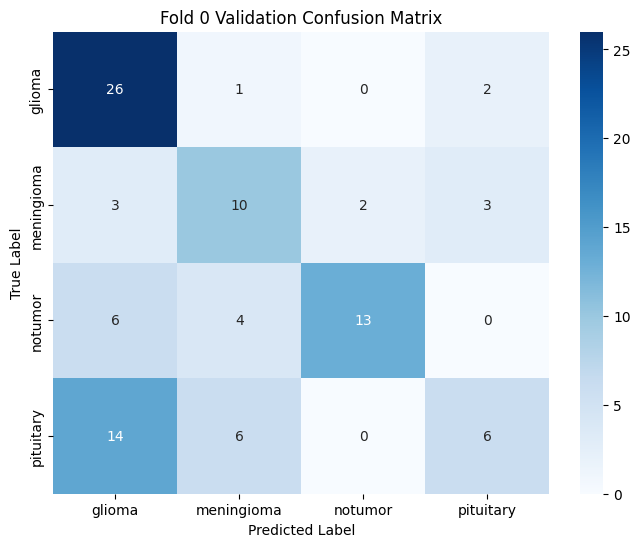

Classification Report for Fold 0:
              precision    recall  f1-score   support

      glioma       0.53      0.90      0.67        29
  meningioma       0.48      0.56      0.51        18
     notumor       0.87      0.57      0.68        23
   pituitary       0.55      0.23      0.32        26

    accuracy                           0.57        96
   macro avg       0.60      0.56      0.55        96
weighted avg       0.60      0.57      0.55        96

Class-wise TP, TN, FP, FN for Fold 0:
Class: glioma, TP: 26, TN: 44, FP: 23, FN: 3
Class: meningioma, TP: 10, TN: 67, FP: 11, FN: 8
Class: notumor, TP: 13, TN: 71, FP: 2, FN: 10
Class: pituitary, TP: 6, TN: 65, FP: 5, FN: 20
Loading model for fold 1...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 113ms/step
Fold 1 - AUC-ROC for class glioma: 0.8086
Fold 1 - AUC-ROC for class meningioma: 0.7386
Fold 1 - AUC-ROC for class notumor: 0.7531
Fold 1 - AUC-ROC for class pituitary: 0.5588


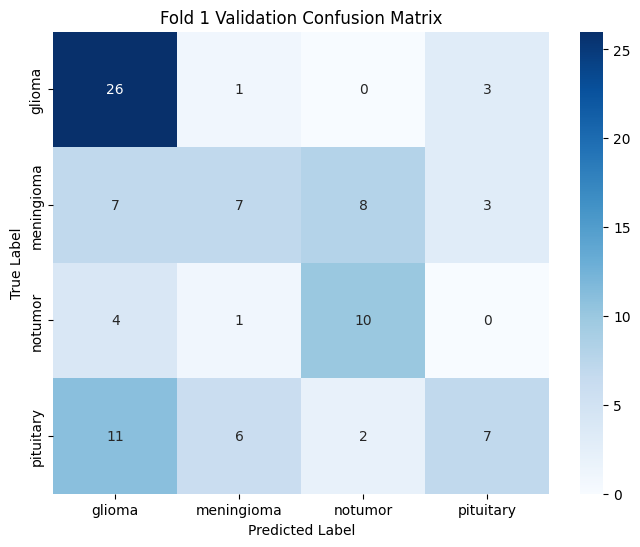

Classification Report for Fold 1:
              precision    recall  f1-score   support

      glioma       0.54      0.87      0.67        30
  meningioma       0.47      0.28      0.35        25
     notumor       0.50      0.67      0.57        15
   pituitary       0.54      0.27      0.36        26

    accuracy                           0.52        96
   macro avg       0.51      0.52      0.49        96
weighted avg       0.51      0.52      0.49        96

Class-wise TP, TN, FP, FN for Fold 1:
Class: glioma, TP: 26, TN: 44, FP: 22, FN: 4
Class: meningioma, TP: 7, TN: 63, FP: 8, FN: 18
Class: notumor, TP: 10, TN: 71, FP: 10, FN: 5
Class: pituitary, TP: 7, TN: 64, FP: 6, FN: 19
Loading model for fold 2...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 3s 118ms/step
Fold 2 - AUC-ROC for class glioma: 0.8352
Fold 2 - AUC-ROC for class meningioma: 0.6247
Fold 2 - AUC-ROC for class notumor: 0.8283
Fold 2 - AUC-ROC for class pituitary: 0.7338


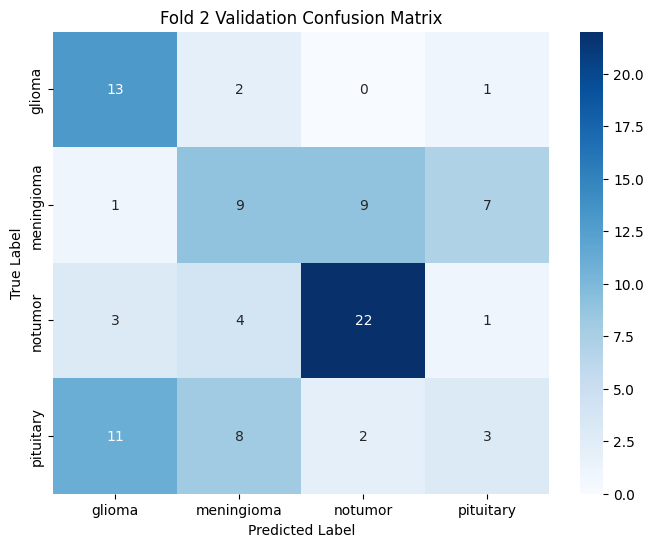

Classification Report for Fold 2:
              precision    recall  f1-score   support

      glioma       0.46      0.81      0.59        16
  meningioma       0.39      0.35      0.37        26
     notumor       0.67      0.73      0.70        30
   pituitary       0.25      0.12      0.17        24

    accuracy                           0.49        96
   macro avg       0.44      0.50      0.46        96
weighted avg       0.45      0.49      0.46        96

Class-wise TP, TN, FP, FN for Fold 2:
Class: glioma, TP: 13, TN: 65, FP: 15, FN: 3
Class: meningioma, TP: 9, TN: 56, FP: 14, FN: 17
Class: notumor, TP: 22, TN: 55, FP: 11, FN: 8
Class: pituitary, TP: 3, TN: 63, FP: 9, FN: 21
Loading model for fold 3...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 121ms/step
Fold 3 - AUC-ROC for class glioma: 0.8273
Fold 3 - AUC-ROC for class meningioma: 0.7017
Fold 3 - AUC-ROC for class notumor: 0.7580
Fold 3 - AUC-ROC for class pituitary: 0.6462


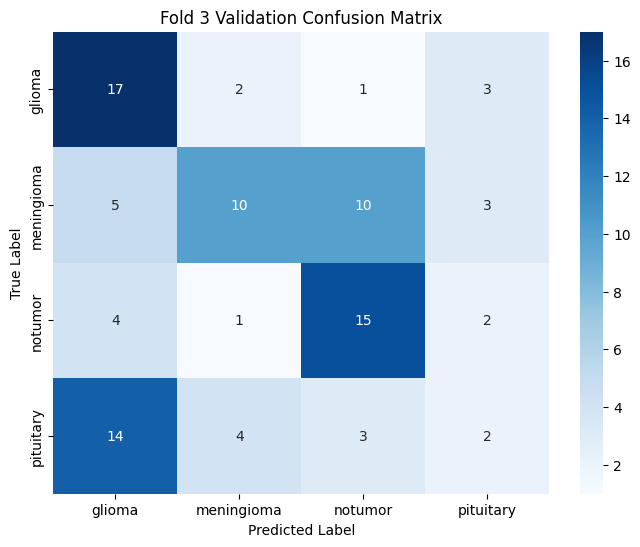

Classification Report for Fold 3:
              precision    recall  f1-score   support

      glioma       0.42      0.74      0.54        23
  meningioma       0.59      0.36      0.44        28
     notumor       0.52      0.68      0.59        22
   pituitary       0.20      0.09      0.12        23

    accuracy                           0.46        96
   macro avg       0.43      0.47      0.42        96
weighted avg       0.44      0.46      0.42        96

Class-wise TP, TN, FP, FN for Fold 3:
Class: glioma, TP: 17, TN: 50, FP: 23, FN: 6
Class: meningioma, TP: 10, TN: 61, FP: 7, FN: 18
Class: notumor, TP: 15, TN: 60, FP: 14, FN: 7
Class: pituitary, TP: 2, TN: 65, FP: 8, FN: 21
Loading model for fold 4...
Found 96 images belonging to 4 classes.
6/6 [==============================] - 2s 134ms/step
Fold 4 - AUC-ROC for class glioma: 0.8495
Fold 4 - AUC-ROC for class meningioma: 0.6754
Fold 4 - AUC-ROC for class notumor: 0.7980
Fold 4 - AUC-ROC for class pituitary: 0.7206


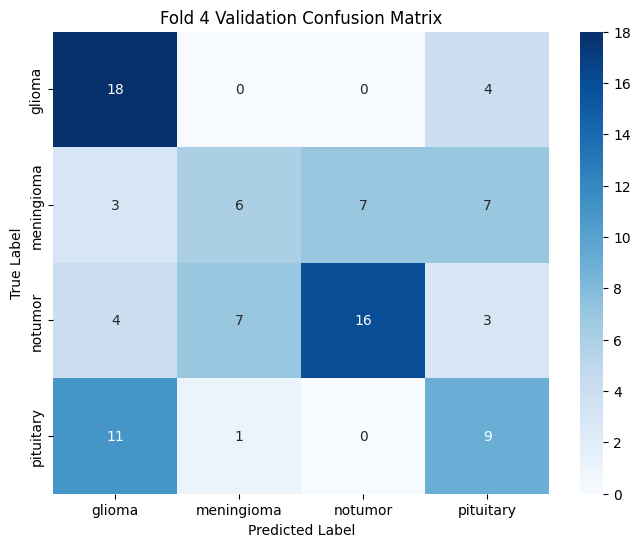

Classification Report for Fold 4:
              precision    recall  f1-score   support

      glioma       0.50      0.82      0.62        22
  meningioma       0.43      0.26      0.32        23
     notumor       0.70      0.53      0.60        30
   pituitary       0.39      0.43      0.41        21

    accuracy                           0.51        96
   macro avg       0.50      0.51      0.49        96
weighted avg       0.52      0.51      0.50        96

Class-wise TP, TN, FP, FN for Fold 4:
Class: glioma, TP: 18, TN: 56, FP: 18, FN: 4
Class: meningioma, TP: 6, TN: 65, FP: 8, FN: 17
Class: notumor, TP: 16, TN: 59, FP: 7, FN: 14
Class: pituitary, TP: 9, TN: 61, FP: 14, FN: 12


In [22]:
# Confusion Matrix, AUC-ROC, and Classification Report for each fold
for fold in range(5):
    print(f'Loading model for fold {fold}...')
    model_path = f'/content/drive/MyDrive/ML Project/inceptionv3_fold_{fold}.h5'
    model = tf.keras.models.load_model(model_path)

    # Load the validation dataset for the current fold
    val_dir = os.path.join(base_dir, f'fold_{fold}', 'val')
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),  # Image size specified here
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Make predictions on the validation data
    val_predictions = model.predict(val_generator)
    val_predictions_classes = np.argmax(val_predictions, axis=1)
    val_true_classes = val_generator.classes

    # Compute the confusion matrix for this fold
    val_conf_matrix = confusion_matrix(val_true_classes, val_predictions_classes)

    # Compute the AUC-ROC for each class
    val_true_classes_one_hot = tf.keras.utils.to_categorical(val_true_classes, num_classes)
    auc_roc_scores = {}
    for i, class_name in enumerate(val_generator.class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_classes_one_hot[:, i], val_predictions[:, i])
        roc_auc = auc(fpr, tpr)
        auc_roc_scores[class_name] = roc_auc
        print(f'Fold {fold} - AUC-ROC for class {class_name}: {roc_auc:.4f}')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Fold {fold} Validation Confusion Matrix')
    plt.show()

    # Print classification report for this fold
    print(f'Classification Report for Fold {fold}:')
    print(classification_report(val_true_classes, val_predictions_classes, target_names=list(val_generator.class_indices.keys())))

    # Calculate TP, TN, FP, FN for each class in this fold
    class_names = list(val_generator.class_indices.keys())
    table_data = []
    for i, class_name in enumerate(class_names):
        tp = val_conf_matrix[i, i]
        fp = np.sum(val_conf_matrix[:, i]) - tp
        fn = np.sum(val_conf_matrix[i, :]) - tp
        tn = np.sum(val_conf_matrix) - tp - fp - fn
        table_data.append([class_name, tp, tn, fp, fn])

    # Print the TP, TN, FP, FN table for this fold
    print(f"Class-wise TP, TN, FP, FN for Fold {fold}:")
    for row in table_data:
        print(f"Class: {row[0]}, TP: {row[1]}, TN: {row[2]}, FP: {row[3]}, FN: {row[4]}")


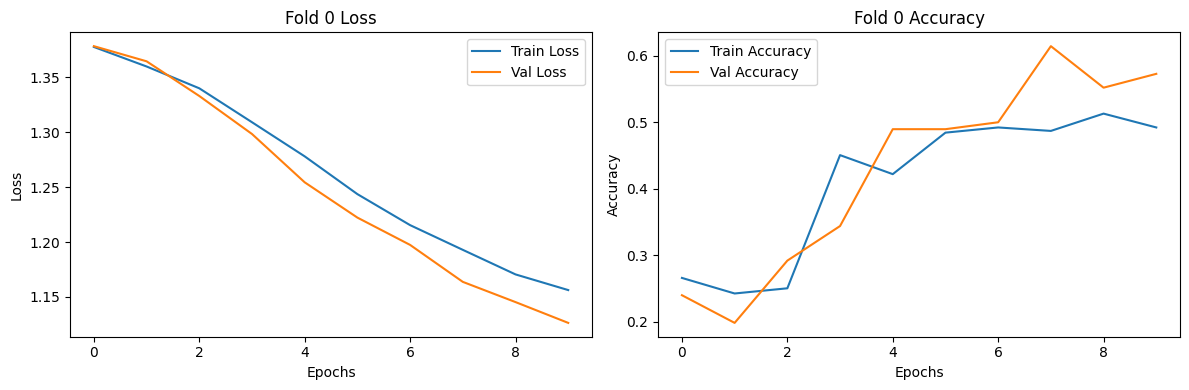

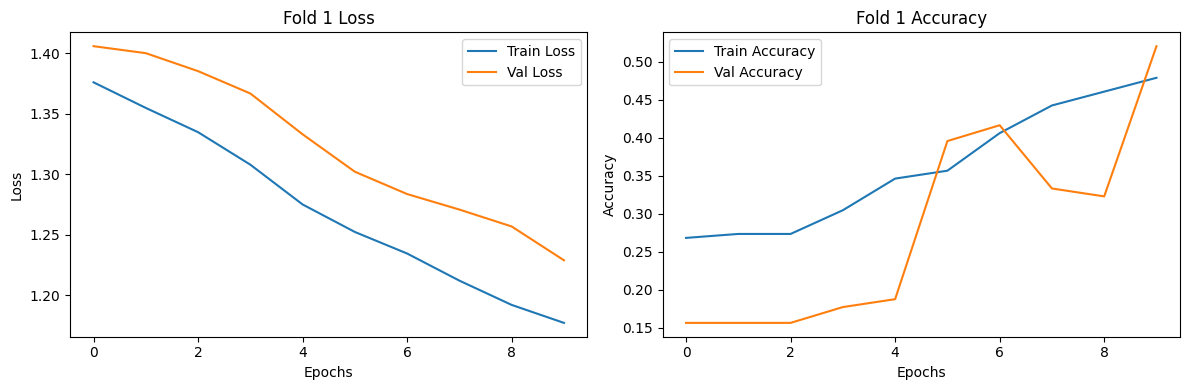

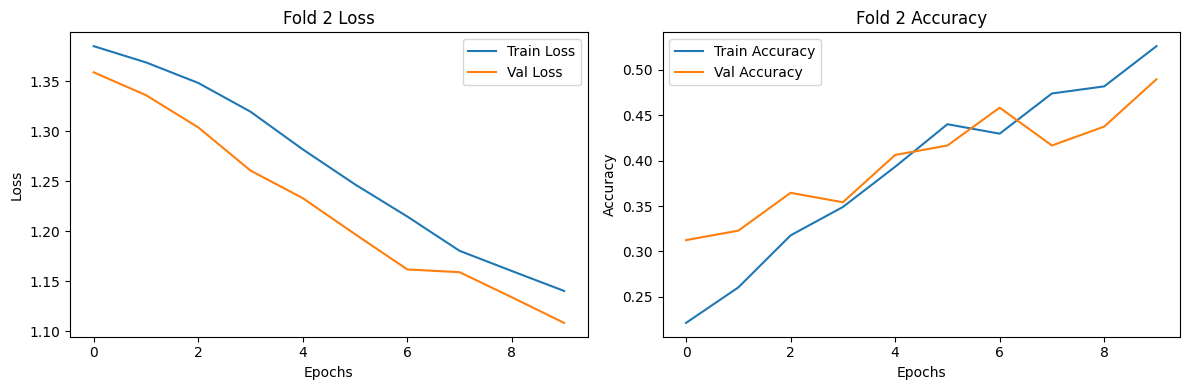

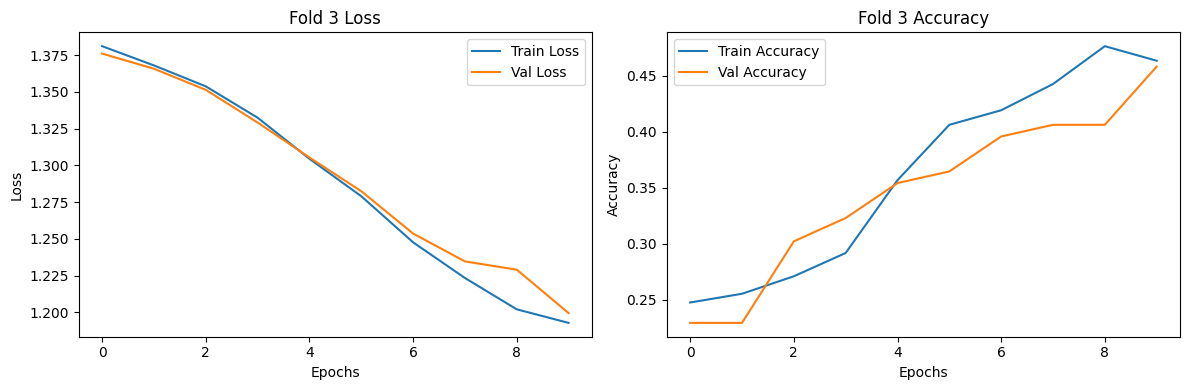

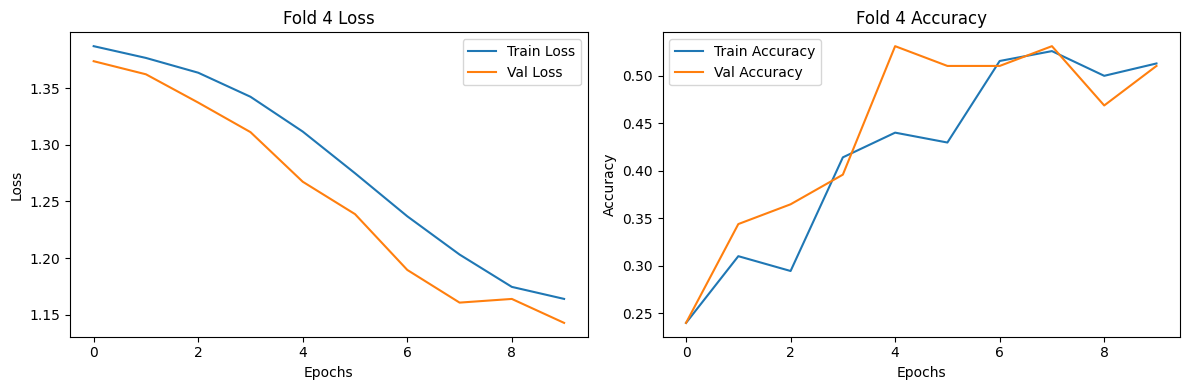

Accuracies for each fold:
Fold 0: 57.29%
Fold 1: 52.08%
Fold 2: 48.96%
Fold 3: 45.83%
Fold 4: 51.04%


In [19]:
# Plotting Results and Printing Fold Accuracies
def plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies):
    for fold in range(5):
        plt.figure(figsize=(12, 4))

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(all_train_losses[fold], label='Train Loss')
        plt.plot(all_val_losses[fold], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Fold {fold} Loss')
        plt.legend()

        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(all_train_accuracies[fold], label='Train Accuracy')
        plt.plot(all_val_accuracies[fold], label='Val Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Fold {fold} Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_results(all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies)

# Print the accuracies for each fold
print("Accuracies for each fold:")
for fold, accuracy in enumerate(fold_accuracies):
    print(f"Fold {fold}: {accuracy * 100:.2f}%")
